## Real Datasets - MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)

    ax = plt.subplot(111)

    ax.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)

            plt.xticks([]), plt.yticks([])
            ax.axis('off')
    if title is not None:
        plt.title(title)
    if savetitle:
        plt.savefig(savetitle, transparent = True)
        
def plot_embedding_cons_par(X, labels_cons,labels_par, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax1.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_cons[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax1.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')
        
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax2.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_par[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax2.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.title('Highest NMI with Consensus Clustering')
    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [3]:
np.shape(X)

(1083, 64)

In [4]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [18]:
def plot_results(data, cl_objects, nmi_arr, anmi_arr, consensus_obj, algorithm, arr_x, arr_y, savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) #+ 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) #+ 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param #+ 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row #-1
        ax.axis('off')
 
        ax.set_aspect('equal')
        ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i], cmap='Set2', alpha=0.2)
        #ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
        if algorithm == 'kmeans':
            ax.set_title('k = {:}, \nNMI = {:.3}\nANMI = {:.3}'.format(k_arr[i], nmi_arr[i], anmi_arr[i]))
            #ax.set_title('k = {:}, \nNMI = {:.3}\nANMI={:.3}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row], anmi_arr[i-num_subplts_per_row]))
        elif algorithm == 'meanshift':
            ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
            #ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}\nANMI={:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row], anmi_arr[i-num_subplts_per_row]))
        elif algorithm == 'dbscan':
#           print(cur_x)
#           print(cur_y)
            ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
            #ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}\nANMI={:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row], anmi_arr[i-num_subplts_per_row]))
        else:
            print("ERROR: Could not recognize algorithm parameter!")
            break
    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle,transparent = True)

In [6]:
def anmi(consensus_obj, labels):
    ''' calculates nmi of every clustering with every other clustering. 
    here the clusterings we are considering are the set of clusterings 
    (with labelling in the label vector) and the consensus clustering (consensus_obj)
    '''
    obj_count=len(labels)+1 #number of clusterings plus the consensus clustering
    nmi_matrix=np.zeros((obj_count,obj_count)) #nmi matrix, note nmi is symmetric
    labels_all=np.concatenate((np.array(labels),np.reshape(consensus_obj.cluster_labels,(1,consensus_obj.cluster_labels.shape[0]))),axis=0)
    for j in range(obj_count):
        for k in range(j+1,obj_count):
            nmi_matrix[k,j]=consensus_obj.compute_nmi(labels_all[j],labels_all[k])
            nmi_matrix[j,k]=nmi_matrix[k,j]
        
    anmi_vector = np.sum(nmi_matrix,axis=0)/(obj_count-1)
    return nmi_matrix, anmi_vector

In [7]:
from sklearn.manifold import TSNE

In [8]:
params = dict(n_components=2, 
          perplexity=30.0, 
          early_exaggeration=5.0, 
          learning_rate=70.0, 
          n_iter=1000, 
          n_iter_without_progress=30, 
          min_grad_norm=1e-07, 
          metric='cityblock', 
          init='random', 
          verbose=0, 
          random_state=None, 
          method='barnes_hut', 
          angle=0.5
             )
tsne = TSNE(**params)
X_tsne = tsne.fit_transform(X)

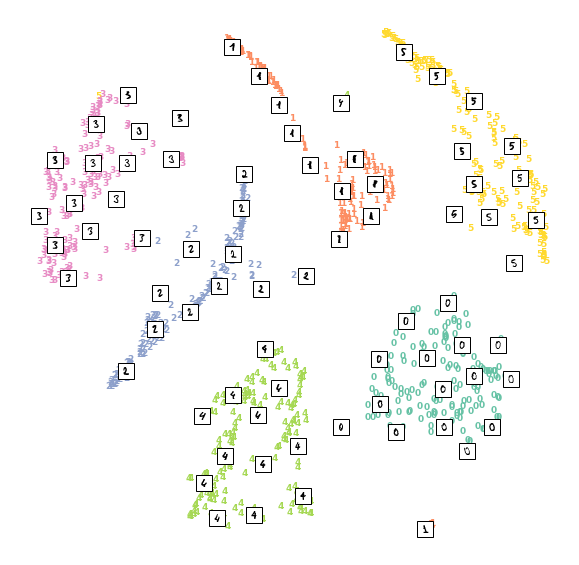

In [9]:
plot_embedding(X_tsne,y,figsize = (10,10))

In [10]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 2
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [11]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 50.0, minPts: 7
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:08.178661
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.18
Consensus clustering terminated.
Finished after 0:00:14.824303
ANMI (average normalized mutual information) of consensus with clusterings: 0.188
Calculate NMI's


## Check ANMI and NMI

In [15]:
#collect all labellings
labels = []
for obj in cl_objects_db:
    labels.append(consensus_obj_db._noise_to_zero(obj).cluster_labels)

nmi_matrix, anmi_vector= anmi(consensus_obj_db, labels)
print(anmi_vector)
print('entry of anmi maximum: ',np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

[ 0.          0.12117375  0.18162009  0.          0.          0.          0.
  0.12904321  0.18389314  0.          0.          0.          0.
  0.13012092  0.18312791  0.          0.          0.          0.
  0.12240354  0.18761599  0.          0.          0.          0.
  0.11313819  0.18642112  0.03591642  0.          0.          0.
  0.10666674  0.18480083  0.03591642  0.          0.          0.18805579]
entry of anmi maximum:  36  and the anmi of that clustering with the rest:  0.188055792092


Number of clusterings: 36


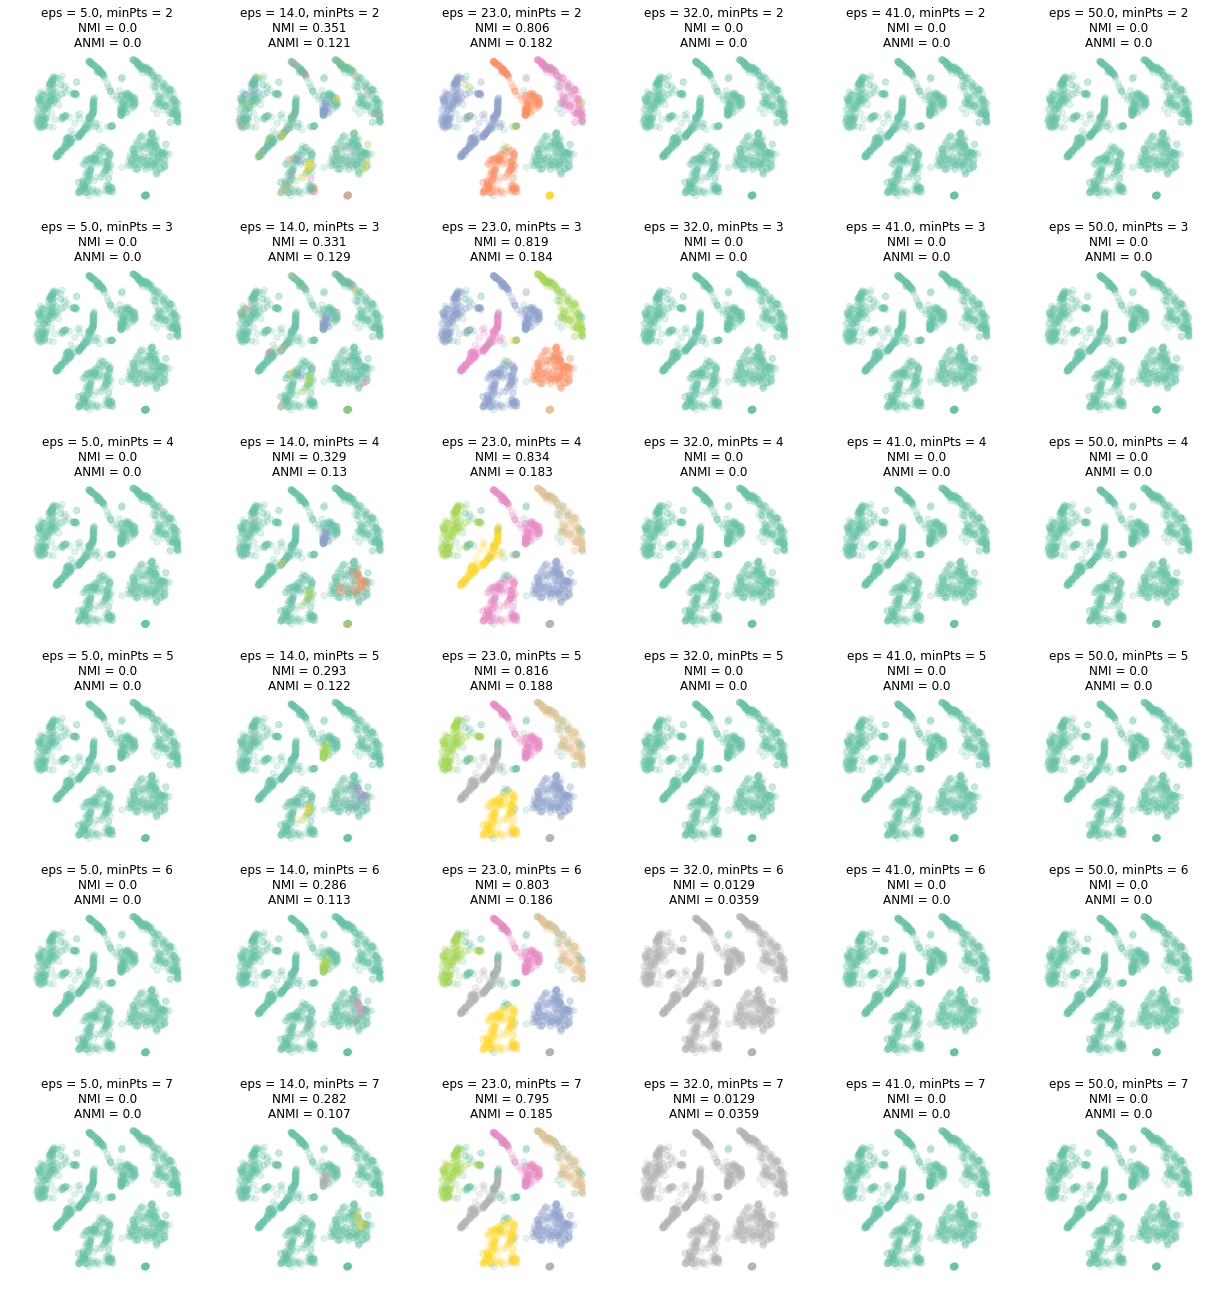

In [19]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, anmi_arr=anmi_vector, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr,
            savetitle = 'img/mnist_dbscan_consensus.pdf')

## Consensus clustering result using DBSCAN vs highest NMI result with consensus

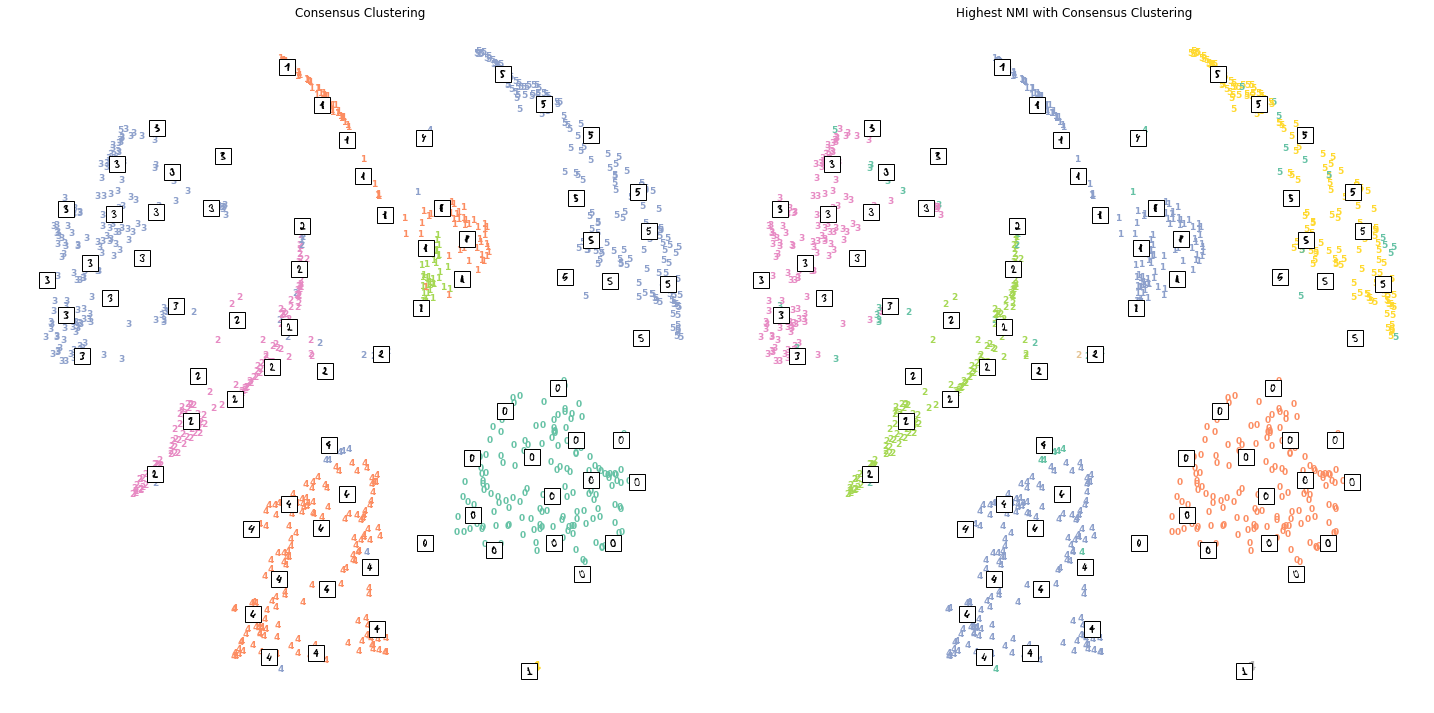

In [20]:
#highest NMI with consensus
best=np.argmax(nmi_arr_db)

obj=cl_objects_db[best]
labels_parametersearch=consensus_obj_db._noise_to_zero(obj).cluster_labels

plot_embedding_cons_par(X_tsne,consensus_obj_db.cluster_labels.astype(int),labels_parametersearch.astype(int),figsize = (20,10),savetitle = 'img/mnist_consensus_dbscan_tSNE.pdf')

In [21]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.833526902998  compared to the consensus result, the best parameters are then eps:  23.0 , minpts:  4


### MEANSHIFT

In [22]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr, mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [23]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
#n_eps = 6
#n_min_pts = 6
#eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
#min_pts_min = 4
#min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
#mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

n_bandwidths = 5
bw_arr = np.linspace(5, 15.0, n_bandwidths)
mindist_arr = np.linspace(0.02, 0.05, 2) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

In [24]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 15.0, mindist: 0.05
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:05.291801
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.44
Consensus clustering terminated.
Finished after 0:00:07.711304
ANMI (average normalized mutual information) of consensus with clusterings: 0.515
Calculate NMI's


## Check ANMI and NMI

In [27]:
#collect all labellings
labels = []
for obj in cl_objects_ms:
    labels.append(consensus_obj_ms._noise_to_zero(obj).cluster_labels)

nmi_matrix, anmi_vector= anmi(consensus_obj_ms, labels)
print(anmi_vector)
print('entry of anmi maximum: ',np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

[ 0.23838678  0.47388151  0.52071388  0.48441554  0.          0.24109725
  0.48024172  0.52071388  0.48441554  0.          0.51459302]
entry of anmi maximum:  2  and the anmi of that clustering with the rest:  0.520713883792


Number of clusterings: 10


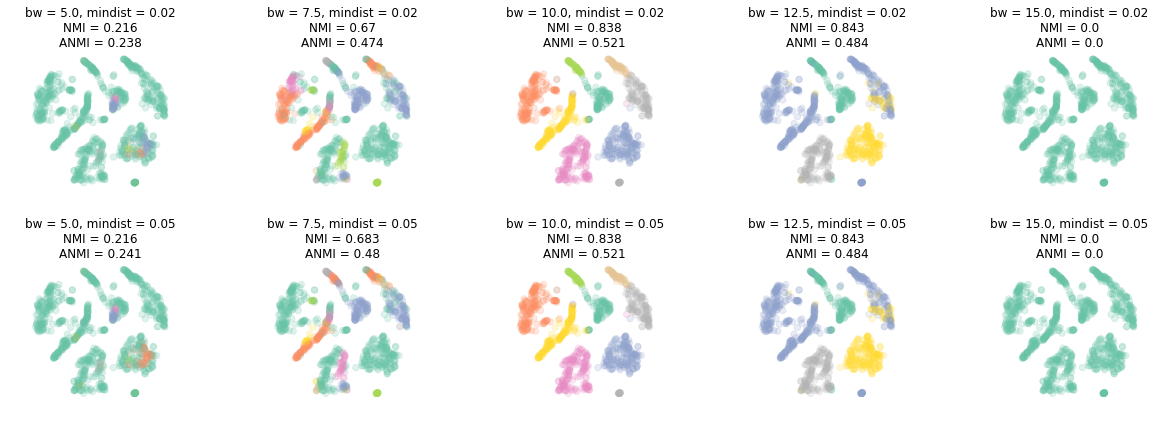

In [28]:
plot_results(data=X_tsne, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, anmi_arr=anmi_vector, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr, savetitle = 'img/mnist_meanshift_consensus.pdf')

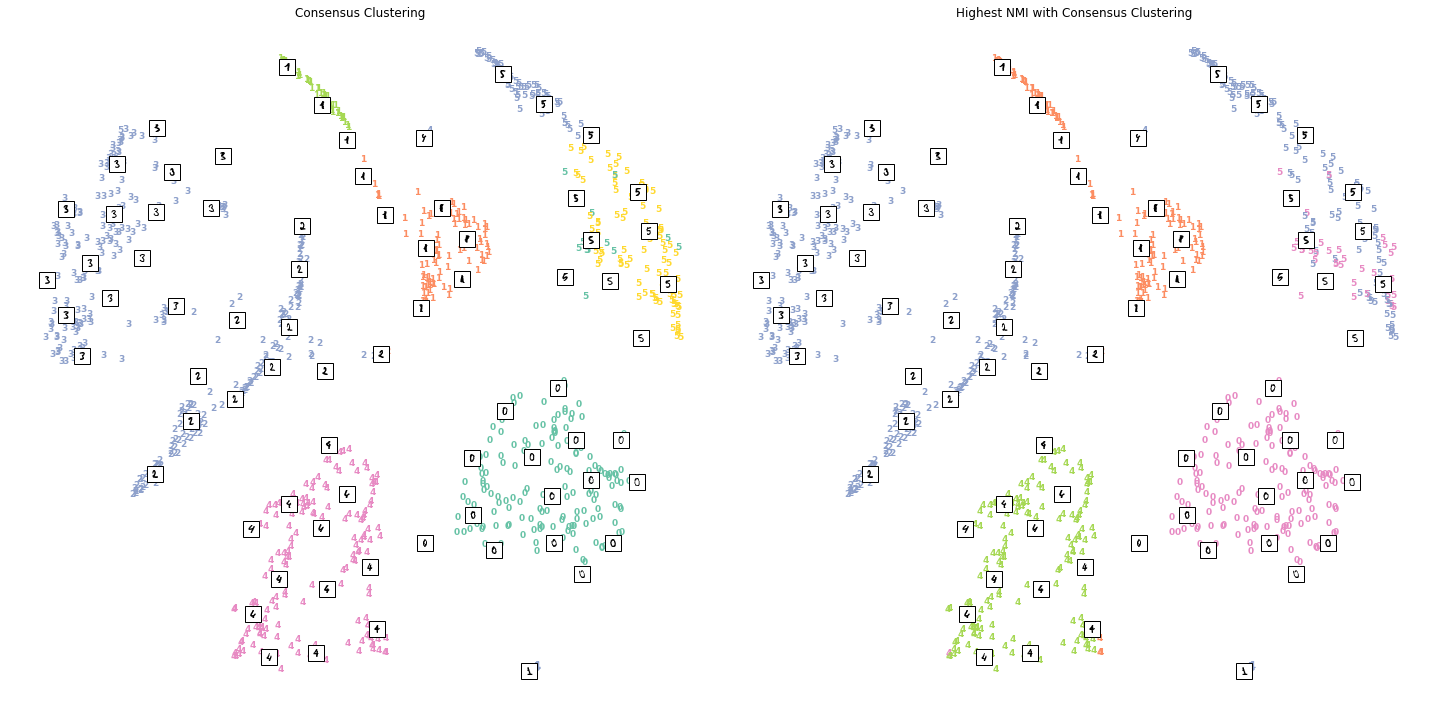

In [29]:
#highest NMI with consensus
best_ms=np.argmax(nmi_arr_ms)

obj=cl_objects_ms[best_ms]
labels_parametersearch_ms=consensus_obj_ms._noise_to_zero(obj).cluster_labels

plot_embedding_cons_par(X_tsne,consensus_obj_ms.cluster_labels.astype(int),labels_parametersearch_ms.astype(int),figsize = (20,10),savetitle = 'img/mnist_consensus_ms_tSNE.pdf')

In [30]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result, the best parameters are then bandwidth: ",mesh_bw.flatten()[best_ms],", mindist: ", mesh_mindist.flatten()[best_ms])

The best parameter choice (given the chosen range) has NMI  0.842879563042  compared to the consensus result, the best parameters are then bandwidth:  12.5 , mindist:  0.02


# Fuzzy Data (Synthetic)

In [31]:
def plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i]),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i]),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [32]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.10, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

np.shape(fuzzy)

(2309, 2)

In [33]:
nmi_arr_db_fz, cl_objects_db_fz, consensus_obj_db_fz = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.1, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:52.895483
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.22
Consensus clustering terminated.
Finished after 0:01:12.628947
ANMI (average normalized mutual information) of consensus with clusterings: 0.356
Calculate NMI's


## NMI and ANMI

In [34]:
#collect all labellings
labels = []
for obj in cl_objects_db_fz:
    labels.append(consensus_obj_db_fz._noise_to_zero(obj).cluster_labels)

nmi_matrix, anmi_vector= anmi(consensus_obj_db_fz, labels)
print(anmi_vector)
print('entry of anmi maximum: ',np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

[ 0.19986545  0.28038481  0.34718734  0.31985998  0.16096861  0.11502343
  0.19735745  0.29134562  0.34934605  0.3425828   0.24325757  0.11502343
  0.18697968  0.2895103   0.34805276  0.34792884  0.26136947  0.11502343
  0.16878864  0.28612858  0.34315496  0.35161898  0.27667616  0.108583
  0.14929634  0.28027179  0.33877666  0.35138944  0.30036201  0.13810742
  0.35636822]
entry of anmi maximum:  30  and the anmi of that clustering with the rest:  0.35636822481


Number of clusterings: 30


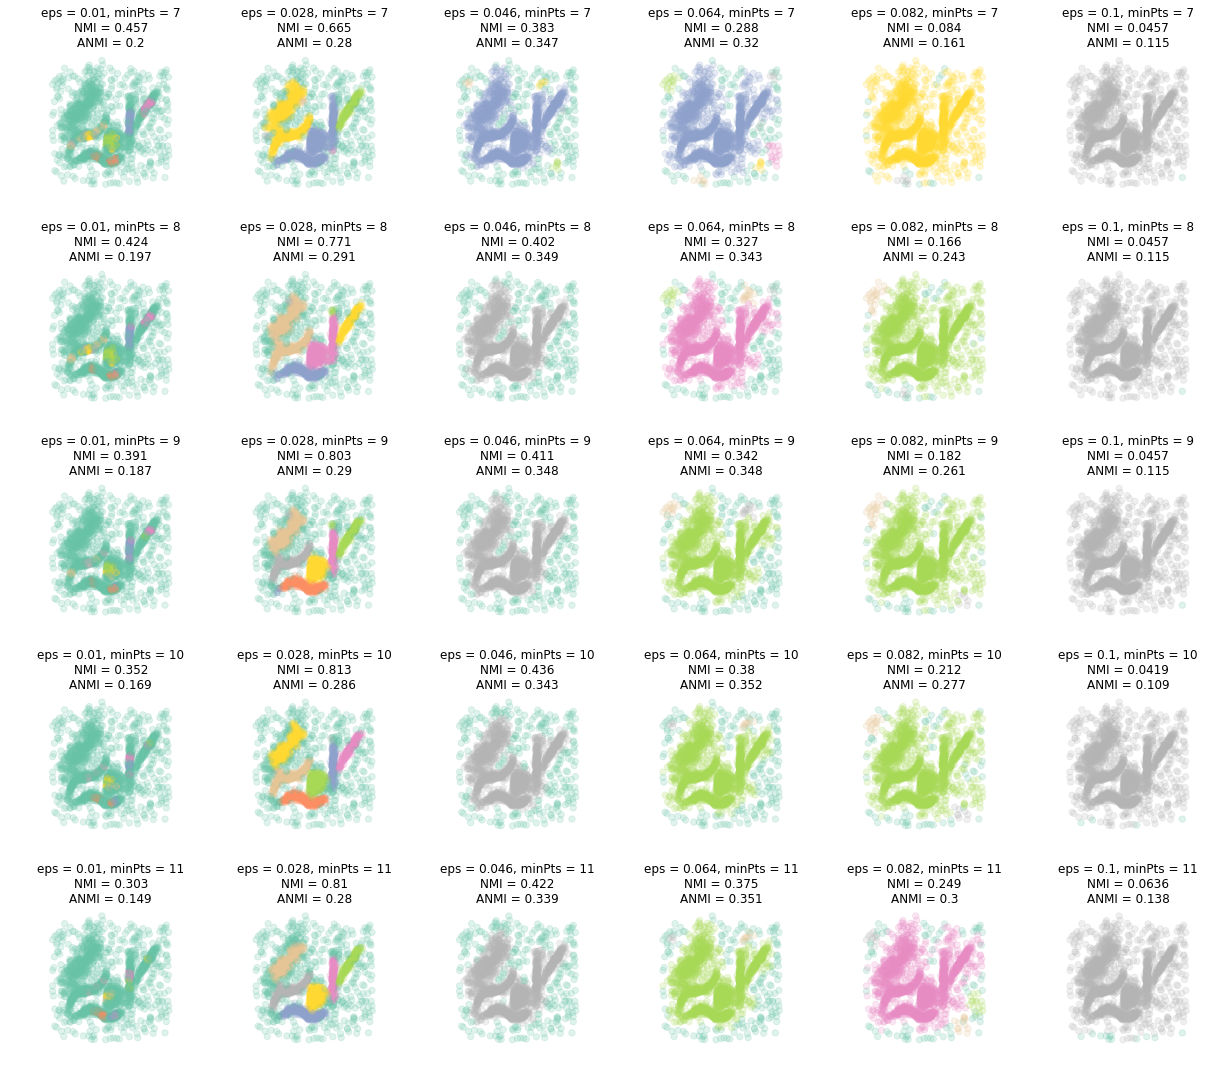

In [36]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_fz, nmi_arr=nmi_arr_db_fz, anmi_arr=anmi_vector, consensus_obj=consensus_obj_db_fz, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/fuzzy_dbscan_consensus.pdf')

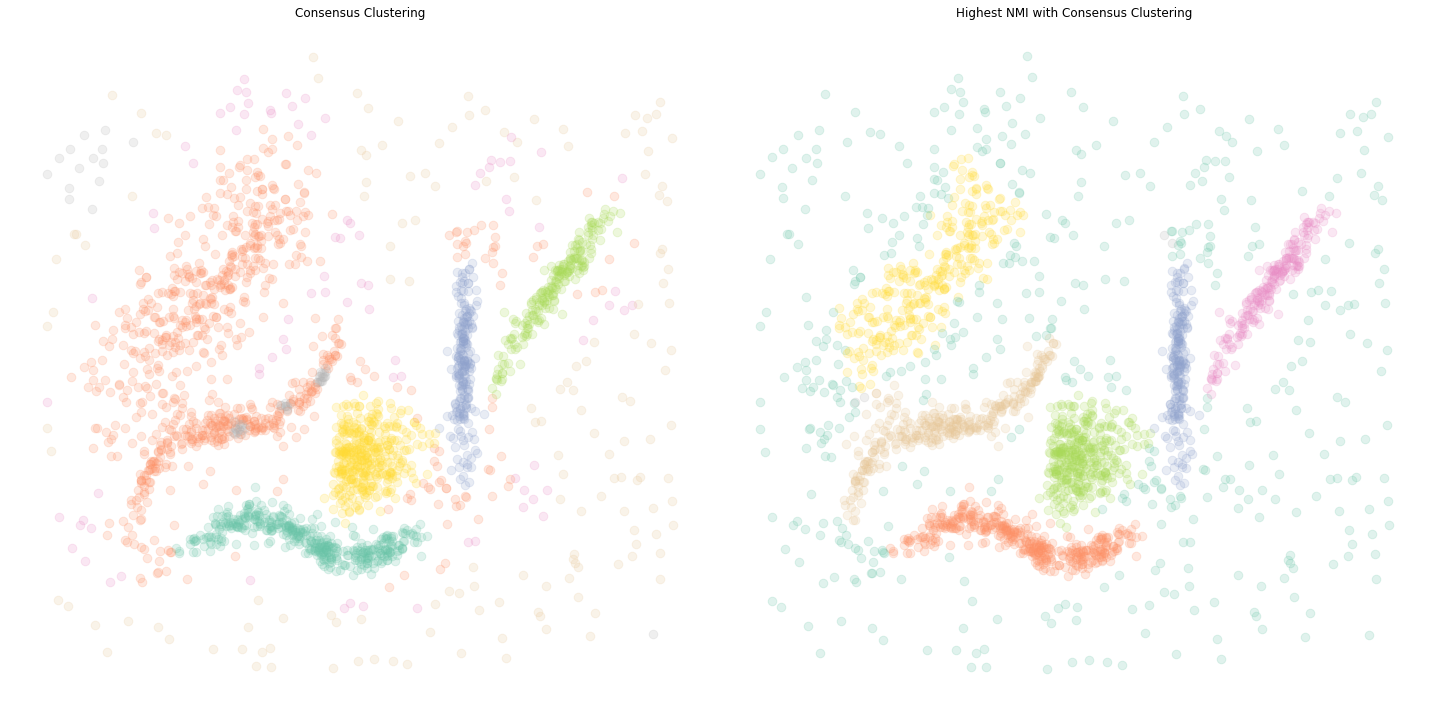

In [37]:
#highest NMI with consensus
best=np.argmax(nmi_arr_db_fz)

obj=cl_objects_db_fz[best]
labels_parametersearch_fz=consensus_obj_db_fz._noise_to_zero(obj).cluster_labels

plot_synth_cons_par(fuzzy,consensus_obj_db_fz.cluster_labels.astype(int),labels_parametersearch_fz,figsize = (20,10),savetitle = 'img/fuzzy_consensus_parametersearch.pdf')

In [38]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db_fz), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.813042691197  compared to the consensus result, the best parameters are then eps:  0.028 , minpts:  10
